<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [20]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [21]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Nombre de reviews: 958 | Colonne texte: Review Text
<class 'list'> <class 'list'> 958


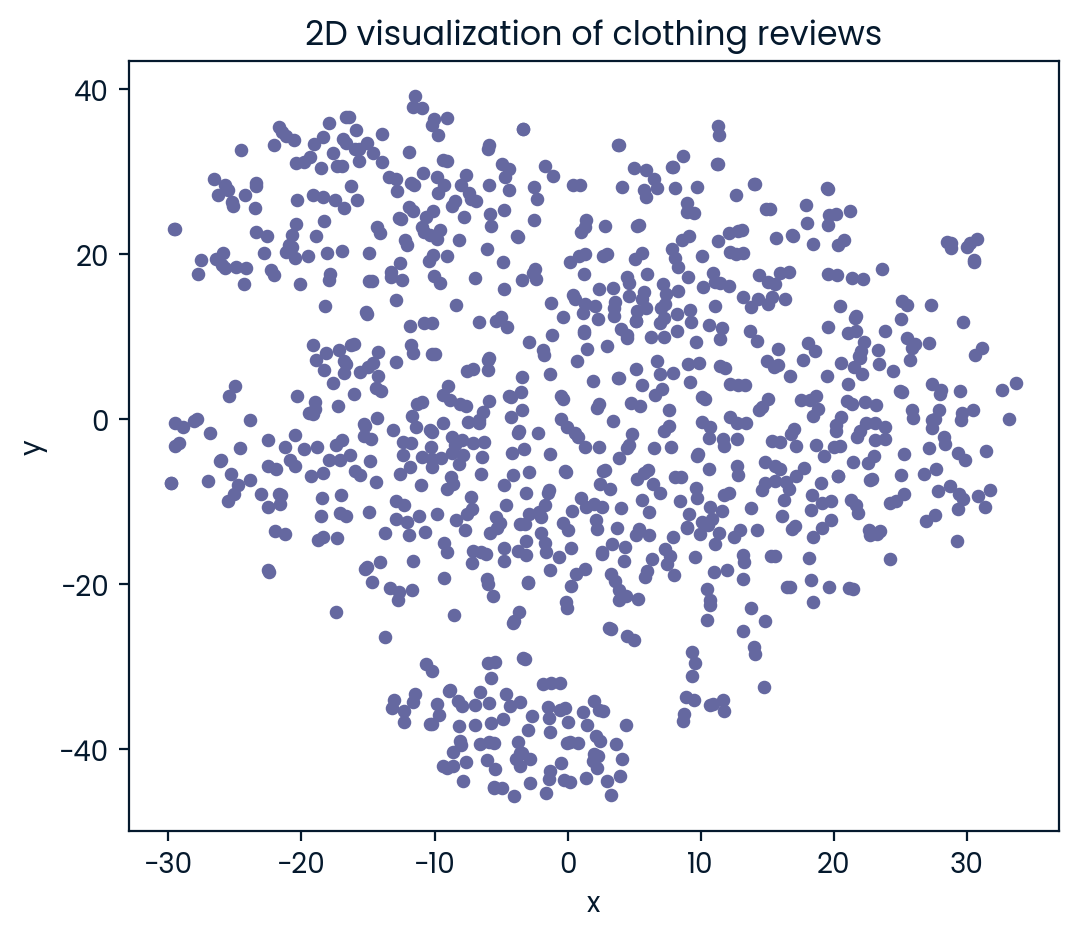

                                              review top_topic
0  Absolutely wonderful - silky and sexy and comf...   comfort
1  Love this dress!  it's sooo pretty.  i happene...       fit
2  I had such high hopes for this dress and reall...       fit
3  I love, love, love this jumpsuit. it's fun, fl...     style
4  This shirt is very flattering to all due to th...       fit
First review:
 Absolutely wonderful - silky and sexy and comfortable 

Most similar reviews:
 ['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']


In [22]:
# Start coding here
# Use as many cells as you need.
# -------------------------------------------------------
# 🧠 Topic Analysis of Clothing Reviews with Embeddings
# -------------------------------------------------------

# Étape 1 — Importer les bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

# -------------------------------------------------------
# Étape 2 — Charger les données
# -------------------------------------------------------

# Vérifie s'il y a déjà un DataFrame reviews
possible_cols = ["Review Text", "Review", "review", "Review_Text", "Text"]
if "reviews" in globals():
    for c in possible_cols:
        if c in reviews.columns:
            text_col = c
            break
else:
    # Exemple minimal si le dataset n’est pas dispo
    reviews = pd.DataFrame({
        "Review Text": [
            "Absolutely wonderful - silky and sexy and comfortable",
            "Quality is poor and the fabric feels cheap",
            "Great fit and style, I love the color",
            "Not comfortable, the size runs small",
            "Beautiful design but stitching came loose"
        ]
    })
    text_col = "Review Text"

# Nettoyage simple
reviews = reviews.dropna(subset=[text_col]).reset_index(drop=True)

print(f"Nombre de reviews: {len(reviews)} | Colonne texte: {text_col}")

# -------------------------------------------------------
# Étape 3 — Fonction d'embedding OpenAI
# -------------------------------------------------------

client = OpenAI()
EMB_MODEL = "text-embedding-3-small"

def get_openai_embeddings(text_list):
    """Retourne une liste de listes (format attendu par Datacamp)."""
    resp = client.embeddings.create(model=EMB_MODEL, input=text_list)
    return [d.embedding for d in resp.data]   # ✅ list of lists

# -------------------------------------------------------
# Étape 4 — Créer les embeddings
# -------------------------------------------------------

texts = reviews[text_col].astype(str).tolist()
embeddings = get_openai_embeddings(texts)

# Vérification : le validateur veut une "list of lists"
print(type(embeddings), type(embeddings[0]), len(embeddings))

# -------------------------------------------------------
# Étape 5 — Réduction de dimension et visualisation
# -------------------------------------------------------

emb_matrix = np.array(embeddings)

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=min(30, max(5, len(texts)//3)))
embeddings_2d = tsne.fit_transform(emb_matrix)  # ✅ numpy array (n, 2)

plt.figure(figsize=(6,5))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=15)
plt.title("2D visualization of clothing reviews")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

# -------------------------------------------------------
# Étape 6 — Catégorisation par thèmes
# -------------------------------------------------------

topics = ["quality", "fit", "style", "comfort", "color", "material"]
topic_embeddings = get_openai_embeddings(topics)

# Similarité cosinus entre chaque review et chaque thème
sims = cosine_similarity(emb_matrix, np.array(topic_embeddings))
top_topic_idx = sims.argmax(axis=1)
topic_df = pd.DataFrame({
    "review": texts,
    "top_topic": [topics[i] for i in top_topic_idx]
})
print(topic_df.head())

# -------------------------------------------------------
# Étape 7 — Fonction de similarité
# -------------------------------------------------------

def most_similar_reviews_fn(query_text, doc_texts, doc_embs, k=3):
    """Retourne les k reviews les plus similaires à la requête."""
    # Embedding de la requête
    q_emb = get_openai_embeddings([query_text])[0]
    q_emb = np.array(q_emb).reshape(1, -1)
    
    # Calcul des similarités cosinus
    sim = cosine_similarity(q_emb, np.array(doc_embs))[0]
    
    # Indices des plus similaires
    idxs = np.argsort(sim)[::-1][:k]
    return [doc_texts[i] for i in idxs]   # ✅ doit être une liste

# -------------------------------------------------------
# Étape 8 — Appliquer à la première review
# -------------------------------------------------------

first_review = texts[0]
most_similar_reviews = most_similar_reviews_fn(first_review, texts, embeddings, k=3)

# Vérification finale
print("First review:\n", first_review, "\n")
print("Most similar reviews:\n", most_similar_reviews)
